# Task: Wifi Positioning with RSSI Fingerprints
You will get a dataset that was gathered by the Minodes team to enable wifi positioning. In this store we installed 145 of our sensors, also called **nodes**. 

As you walk through the store your phone searches for available wifi networks, by sending probe requests (see 802.11 standard). A part of this probe request is the received signal strength indication (**RSSI**), which has a range between 0db (very strong signal) and -100db (very weak signal). Depending on the distance of your phone to a sensor, the **RSSI** has a different value. In an ideal case one probe request would be perceived by all nodes of the store with different signal strength. In our data processing we collect all this probe requests and aggregate them, so that we have all **RSSI** values for all nodes of one probe request available:

A data set might look like this:


|  ID             | RSSI value node 1 | RSSI value node 2  | .... | RSSI value node n  | fr_zone_id |
| -------------   |-------------      | -----              | -----| -------------------| ------- |
| 1               |-70                | -70                | .... |  -70               | 1       |
| 2               |-55                | -60                | .... |  -45               | 2       |
| 2               |-60                | -60                | .... |  -45               | 2       |
| ...             |.......            | ....               | .... | ....               | ..      |

Each line of this the table is called a fingerprint, which gives us an indication about the potential location of a person.

To locate a person within the store, we separate the store into zones representing compartments of a store. For each of this **zones** we collect reference data, which is stored in the file *training_set.csv* of this exercise.

The goal of this task is to use machine learning techniques to predict the correct zones, based on **RSSI** fingerprints. At the end of this task you need to predict the zones of unkown **RSSI** fingerprints stored in the file *test_without_target.csv*. 

Since we at Minodes love to code, we have done some preparation work, so you can focus on the machine learning.

In case you have any questions please contact **alexander.mueller@minodes.com**

## Remarks

* Please use python 3.x
* I suggest using an anaconda python distribution https://www.continuum.io/downloads
* The code is tested in python 3.4
* Please use pre-existing libraries

## Requirements
The current versions of:
* pandas 
* numpy

## Some imports and a preprocessing routine

In [406]:
%matplotlib inline

import ast
from math import *
import pandas as pd
import numpy as np
from sklearn.feature_extraction import DictVectorizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import neighbors, cluster
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split

def preprocess_x_values(x_raw_values):
    """
    A simple preprocessing routine returning a feature vector for the specific fingerprint. 
    """

    v = DictVectorizer(sparse=False)
    
    return v.fit_transform(x_raw_values)

### Loading the data

In [ ]:
training_set = pd.read_csv('training_set.csv')

In [ ]:
# Load training data

# Parse dictionary of features
training_set['values'] =training_set['values'].apply(lambda x:  ast.literal_eval(x))

# preparing x and y sets 
# x are the features of the set
# y is the class to be predicted
x_raw = training_set['values']
y = training_set['fr_zone_id']

# preprocess the node dictionary to get feature vectors
x_features= preprocess_x_values(x_raw)

In [107]:
x_features.shape

(63134, 137)

In [5]:
x_features

array([[  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0., -75., -71., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       ..., 
       [  0.,   0.,   0., ..., -75.,   0., -78.],
       [-54., -58., -50., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]])

### Implementation

Think about how you validate your model (based on accuracy), what classifier you want to use and how in the end you want to scorce the test set.

You need to add only a couple of lines of code to have a basic solution. Do this first and then iterate on it.

In [124]:
#  number of unique zones
y.unique().size

11.053014730672343

In [414]:
#train vs validation set
train_rows = np.random.randint(0,x_features.shape[0],round(x_features.shape[0]*(2/3)))
x_train, x_valid, y_train, y_valid = train_test_split(x_features, y,  test_size=1/3)
x_train.shape[0]+x_valid.shape[0]

63134

In [415]:
#how many features could I choose based on training data?
log10(x_train.shape[0])

4.624168607391142

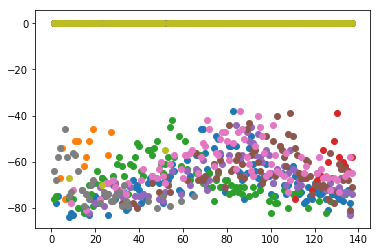

In [412]:
#visualization
for i in range(1,10):
    plt.scatter(np.arange(1,x_train[i].size+1,1), x_train[i])

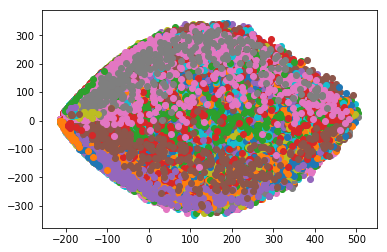

In [418]:
#visualization cont'd
pca = PCA(n_components=2)
X_red = pca.fit(x_train).transform(x_train)

target_names = y_train.unique()
plt.figure()
for target_name in target_names:
    plt.scatter(X_red[y_train == target_name, 0], X_red[y_train == target_name, 1],
                label=target_name)

In [421]:
# feature selection:
sb = SelectKBest(k=20)
X_new = sb.fit_transform(x_train, y_train)
X_new.shape
rem_nodes =list(sb.get_support())

In [423]:
#dimensionality reduction with PCA -  not really useful
pca = PCA(n_components=4)
X_red = pca.fit(X_new).transform(X_new)

target_names = y.unique()
# Percentage of variance explained for each components
print('Explained variance ratio: %s'
      % str(pca.explained_variance_ratio_))
# Percentage of total variance explained
print('Total explained: %s'
      % str(sum(pca.explained_variance_ratio_)))
# Components
print('Components: %s'
      % str(pca.components_))

Explained variance ratio: [ 0.44279364  0.13180239  0.06556606  0.0398602 ]
Total explained: 0.680022287964
Components: [[-0.25162405 -0.26380126 -0.30166622 -0.19452518 -0.15443415 -0.095314
  -0.11955099 -0.30578995 -0.2295467  -0.28387699 -0.24374756 -0.31646802
  -0.22130619 -0.27202351 -0.2612271  -0.26238953  0.1215845   0.09983121
   0.09569325  0.10347477]
 [-0.03108073 -0.05569144 -0.0820912   0.01113685  0.01391379  0.03379949
   0.03799313 -0.11226478 -0.0527183  -0.02468212 -0.08090998 -0.09987113
  -0.09065627 -0.02376637 -0.10716206 -0.03074596 -0.46742386 -0.50617692
  -0.48912945 -0.46756533]
 [-0.19397826 -0.15271022  0.03439529 -0.3612383  -0.27612153 -0.32799905
  -0.36665263  0.32205994  0.00499269 -0.22056187  0.29229687  0.25044072
   0.25437246 -0.16718238  0.24832614 -0.10719759 -0.08619499 -0.05695451
  -0.07271679 -0.08239266]
 [ 0.33693384  0.31761905 -0.0022371   0.0936544   0.02092631  0.04258546
   0.01956842 -0.09342416 -0.15361504 -0.19303731  0.43140363

In [425]:
#train kNN classification model: all features are equally weighted (curse of dimensionality)
#I should only use the features that are really important
k_neighbors=15
clf = neighbors.KNeighborsClassifier(k_neighbors, weights="distance")
clf.fit(X_new, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=15, p=2,
           weights='distance')

In [426]:
#validation, fine tuning of parameters
scores = clf.score(X_new, y_train)
scores

0.61182256646629762

### Predict and unkown dataset

In [301]:
test_set = pd.read_csv('test_without_target.csv',index_col='id')
test_set['values'] = test_set['values'].apply(lambda x:  ast.literal_eval(x))
x_test= preprocess_x_values(test_set['values'])
x_test = x_test[:,rem_nodes]
x_test.shape

0.7754933950011087

In [292]:
prediction = clf.predict(x_test)
probs = clf.predict_proba(x_test)

### Submit your solution
Please zip the complete folder with your solution and send it back to **alexander.mueller@minodes.com**. We will review it as soon as possible and will come back to you!